In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

1. Lage en tom testmappe i data mappen.
2. Legge til MURAv1.1 med train og valid mappene i data mappen.(kan slette de csv filene som følger med i MURA-v1.1) 
3. Kjøre scriptet "renaming_and_move_test_files"
4. Kjøre notebooken (edited)

# MURA

In [2]:
import sys
import os.path
sys.path.append("../../fastai/")

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

/home/sathiesh/.conda/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sathiesh/.conda/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sathiesh/.conda/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
# See how many devices are around
torch.cuda.device_count()
# Set it to a particular device
torch.cuda.set_device(1)
# Check which device you are on
torch.cuda.current_device()

1

In [5]:
NB_DIR = %pwd
PATH = f'{NB_DIR}/data/'

In [6]:
cleaned_label_path = f'{PATH}cleaned_label.csv'

In [7]:
os.path.isfile(cleaned_label_path) #hvis den er laget kan man skippe til load cleaned label

True

 # Hopp til load cleanled label hvis filen finnes fra før av

In [ ]:
df_train_image_paths = pd.read_csv(f'{PATH}train_image_paths.csv',header=None)
df_train_labeled_studies = pd.read_csv(f'{PATH}train_labeled_studies.csv', header=None)

In [ ]:
df_train_image_paths.columns = ['Image Index']

In [ ]:
df_train_labeled_studies.columns = ['Image Index', 'Abnormality']

In [ ]:
#finne indeksen 
df_train_image_paths['Abnormality'] = np.nan

In [ ]:
total = 0; 
for index, row in df_train_labeled_studies.iterrows():
    studie_name = row['Image Index']
    studie_abnormality = row['Abnormality']
    
    df = df_train_image_paths['Image Index'].str.contains(studie_name)
    df = df[df]
    idx_list = list(df.index)
    df_train_image_paths.loc[idx_list, 'Abnormality'] = studie_abnormality      
    total = total + len(idx_list);

In [ ]:
df_train_image_paths.shape, total

In [ ]:
df_train_image_paths.head()

In [ ]:
df_sorted = df_train_image_paths.pivot_table(index='Abnormality', aggfunc=len).sort_values('Image Index') 
df_sorted.index = ['Abnormal','Normal']
df_sorted['Image Index'].plot(kind='bar', title="Abnormal vs Normal")

In [ ]:
df_train_image_paths.to_csv(cleaned_label_path, index=False)

In [ ]:
df_sorted.index

# Load cleaned label

In [13]:
df_train_image_paths = pd.read_csv(cleaned_label_path)

In [14]:
n = len(df_train_image_paths)-1
val_idxs = get_cv_idxs(n, val_pct=0.15) 

In [15]:
len(val_idxs)

5521

In [16]:
df_train_image_paths.shape

(36808, 2)

# View data

In [17]:
sz = 64
arch = dn121
bs = 32

In [18]:
#aug_tfms = [RandomLighting(b=0, c=8), RandomFlip()]
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
  #transforms_side_on
    return ImageClassifierData.from_csv(PATH ,'', cleaned_label_path , tfms=tfms, bs=bs, val_idxs = 0);

In [19]:
data = get_data(sz)

In [20]:
data.trn_ds.fnames.shape ,data.val_ds.fnames.shape

((36807,), (1,))

# Training

In [18]:
learn = ConvLearner.pretrained(arch, data, ps = 0.4, opt_fn=optim.Adam) 

 69%|██████▉   | 794/1151 [00:36<00:16, 21.63it/s, loss=2.79] 

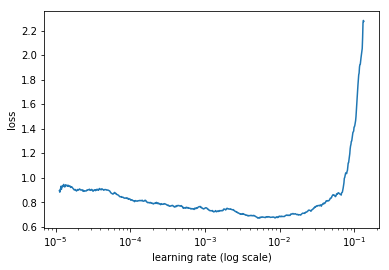

In [19]:
learn.lr_find()
learn.sched.plot()

In [20]:
lr = 0.001

In [21]:
learn.fit(lr,2, cycle_len=1, cycle_mult=2) 

epoch      trn_loss   val_loss   accuracy                      
    0      0.57146    0.32439    1.0       
    1      0.582336   0.280832   1.0                           
    2      0.571686   0.336244   1.0                           


[array([0.33624]), 1.0]

In [22]:
lrs = [lr/9, lr/3, lr] #TODO uten TL bør jeg dele på 9 og 3
learn.unfreeze()

In [23]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.538574   0.207386   1.0       
    1      0.501793   0.240372   1.0                           
    2      0.4696     0.090111   1.0                           


[array([0.09011]), 1.0]

In [24]:
sz = 128

In [25]:
learn.set_data(get_data(sz))
learn.freeze()

In [26]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.497644   0.216528   1.0       
    1      0.478628   0.23562    1.0                           
    2      0.472709   0.235517   1.0                           


[array([0.23552]), 1.0]

In [27]:
learn.unfreeze();
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.475468   0.245876   1.0       
    1      0.459452   0.170237   1.0                           
    2      0.419816   0.216955   1.0                           


[array([0.21696]), 1.0]

In [28]:
sz = 299

In [29]:
learn.set_data(get_data(sz))
learn.freeze() 

In [30]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.473335   0.205846   1.0       
    1      0.472268   0.185678   1.0                           
    2      0.474707   0.199957   1.0                           


[array([0.19996]), 1.0]

In [31]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}trening1')

epoch      trn_loss   val_loss   accuracy                      
    0      0.446017   0.280559   1.0       
    1      0.42798    0.26609    1.0                           
    2      0.409484   0.184348   1.0                           


In [32]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}trening2')

epoch      trn_loss   val_loss   accuracy                      
    0      0.405708   0.181311   1.0       
    1      0.406056   0.287017   1.0                           
    2      0.384854   0.1085     1.0                           


In [33]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}trening3')

epoch      trn_loss   val_loss   accuracy                      
    0      0.389932   0.193664   1.0       
    1      0.39003    0.095772   1.0                           
    2      0.386296   0.137972   1.0                           


# Prediction on test set

In [23]:
sz = 299
data = get_data(sz)
learn = ConvLearner.pretrained(arch, data, ps = 0.4, opt_fn=optim.Adam) 
learn.load("299trening3")

In [24]:
df_test = pd.read_csv(cleaned_label_path)
df_test.head()

,Image Index,Abnormality
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1.0
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1.0
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1.0
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1.0
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1.0


### Predict studies 

In [25]:
trn_tfms, val_tfms = tfms_from_model(arch, sz) # get transformations
def predict_abnormality(fn): 
    im = open_image(fn)
    im_val = val_tfms(im)
    preds = learn.predict_array(im_val[None])
    return np.argmax(preds)
    #return preds

In [26]:
arr = []; 
for index, row in df_test.iterrows():     
    prediction = predict_abnormality(PATH+row['Image Index'])
    #prob = np.power(10, prediction[0][1])
    if (row['Abnormality'] == 1 and prediction != 1): #and prob < 0.6
        arr.append(row['Image Index'])

In [27]:
len(arr) #tidligere 3544 m treningaug3, #3373 m trening2

3290

In [28]:
x = np.array(df_test['Abnormality'].values, dtype=bool)

In [29]:
df_test[x].size

29746

In [30]:
file_name = 'remove_insecure_images.txt'

In [31]:
file = open(file_name, 'w')
for item in arr:
  file.write("%s\n" % item)
file.close()

In [33]:
f = open(file_name, 'r')
arr = f.read().splitlines()
f.close()

In [34]:
category_dict = {}
img_paths = []
for img in arr: 
    category = img.split('/')[2]
    if category not in category_dict: 
        category_dict[category] = 1
        img_paths.append(PATH+img)
    else: 
        category_dict[category] +=1

In [35]:
category_dict

{'XR_SHOULDER': 754,
 'XR_HUMERUS': 87,
 'XR_FINGER': 559,
 'XR_ELBOW': 406,
 'XR_WRIST': 743,
 'XR_FOREARM': 143,
 'XR_HAND': 598}

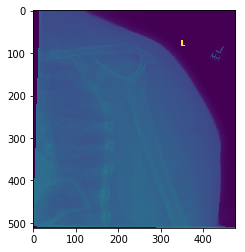

In [36]:
img= matplotlib.image.imread(img_paths[0])
imgplot = plt.imshow(img)

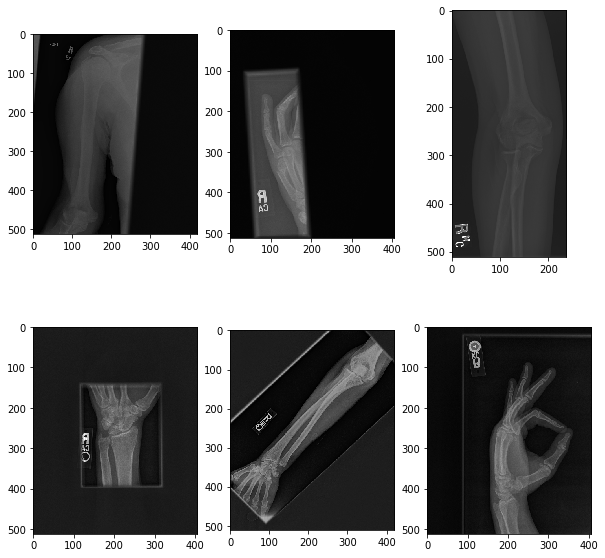

In [37]:
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = Image.open(img_paths[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [38]:
len(arr)

3290

In [39]:
for img in arr: 
    df_test = df_test[df_test['Image Index'].str.contains(img) == False]

In [40]:
len(df_test)

33518

In [41]:
df_test.to_csv(f'{PATH}new_cleaned_label.csv', index=False)

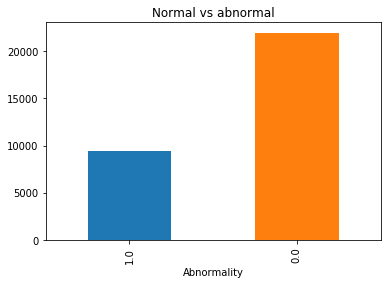

In [42]:
df_test = pd.read_csv(f'{PATH}new_cleaned_label06.csv')
df_sorted = df_test.pivot_table(index='Abnormality', aggfunc=len).sort_values('Image Index') 
df_sorted['Image Index'].plot(kind='bar', title="Normal vs abnormal")